# #5 Conversion to KG

In [1]:
import pandas as pd
import requests
import os

In [2]:
df = pd.read_csv('../Dataset/final_df.csv')
df.head()

,Respondent ID,Gender,Age,BMI,Chromium [nmol/L],Cobalt [nmol/L],Ferritin [ng/mL],Iron frozen [umol/L],UIBC [umol/L],Total Iron Binding Capacity [umol/L],...,Non_HDL Ratio,LDL_HDL Ratio,Total Cholestrol_HDL Ratio,Triglyceride_HDL Ratio,Lymphocyte_Monocyte Ratio,Neutrophil_Lymphocyte Ratio,Platelet_Lymphocyte Ratio,Platelet_WBC Ratio,Lymphocyte_C-Reactive Protein Ratio,Systemic Immune‐inflammation Index (SII)
0,93703.0,0.0,2.0,17.5,6.787297,3.653375,133.394928,15.448058,43.34484,58.796572,...,126.497004,2.042228,3.368882,0.883438,4.166667,1.600000,103.700053,35.113980,7.268033,414.800213
1,93704.0,1.0,2.0,15.7,6.787297,3.653375,36.600000,15.448058,43.34484,58.796572,...,126.497004,2.042228,3.368882,0.883438,5.833333,0.914286,68.285714,32.297297,120.689655,218.514286
2,93705.0,0.0,66.0,31.7,5.580000,3.390000,28.700000,16.500000,41.73000,58.210000,...,97.061098,1.819441,2.619355,0.787064,5.666667,1.235294,90.882353,35.930233,12.500000,381.705882
3,93706.0,1.0,18.0,21.5,6.787297,3.653375,284.000000,29.400000,27.76000,57.130000,...,100.928074,2.311585,3.139344,0.999958,2.500000,2.466667,155.333333,38.196721,20.270270,574.733333
4,93707.0,1.0,13.0,18.1,6.787297,3.653375,49.300000,16.300000,60.89000,77.190000,...,121.036350,1.602348,2.778409,0.693153,6.000000,1.452381,82.857143,31.071429,131.250000,505.428571


In [3]:
# We now convert this dataset into a Knowledge-Graph
# Knowledge graph is a knowledge base that uses a graph-structured data model or topology to integrate data.
# There are several advantages in using Knowledge Graphs
# Some of the advantages with respect to this specific case is that knowledge graphs are more flexible
# This allows us to modify data easily than a relational model
# This is especially useful since medical data is not static and changes will have to be updated
# Also, it helps in adding more components or even diseases in the future
# Moreover there are additional benefits like improved efficiency in storing and retrieving information,
# along with the potential to integrate supplementary data or databases

# To convert this to a knowledge graph (using Neo4j) we should make csv files for each node and relationships

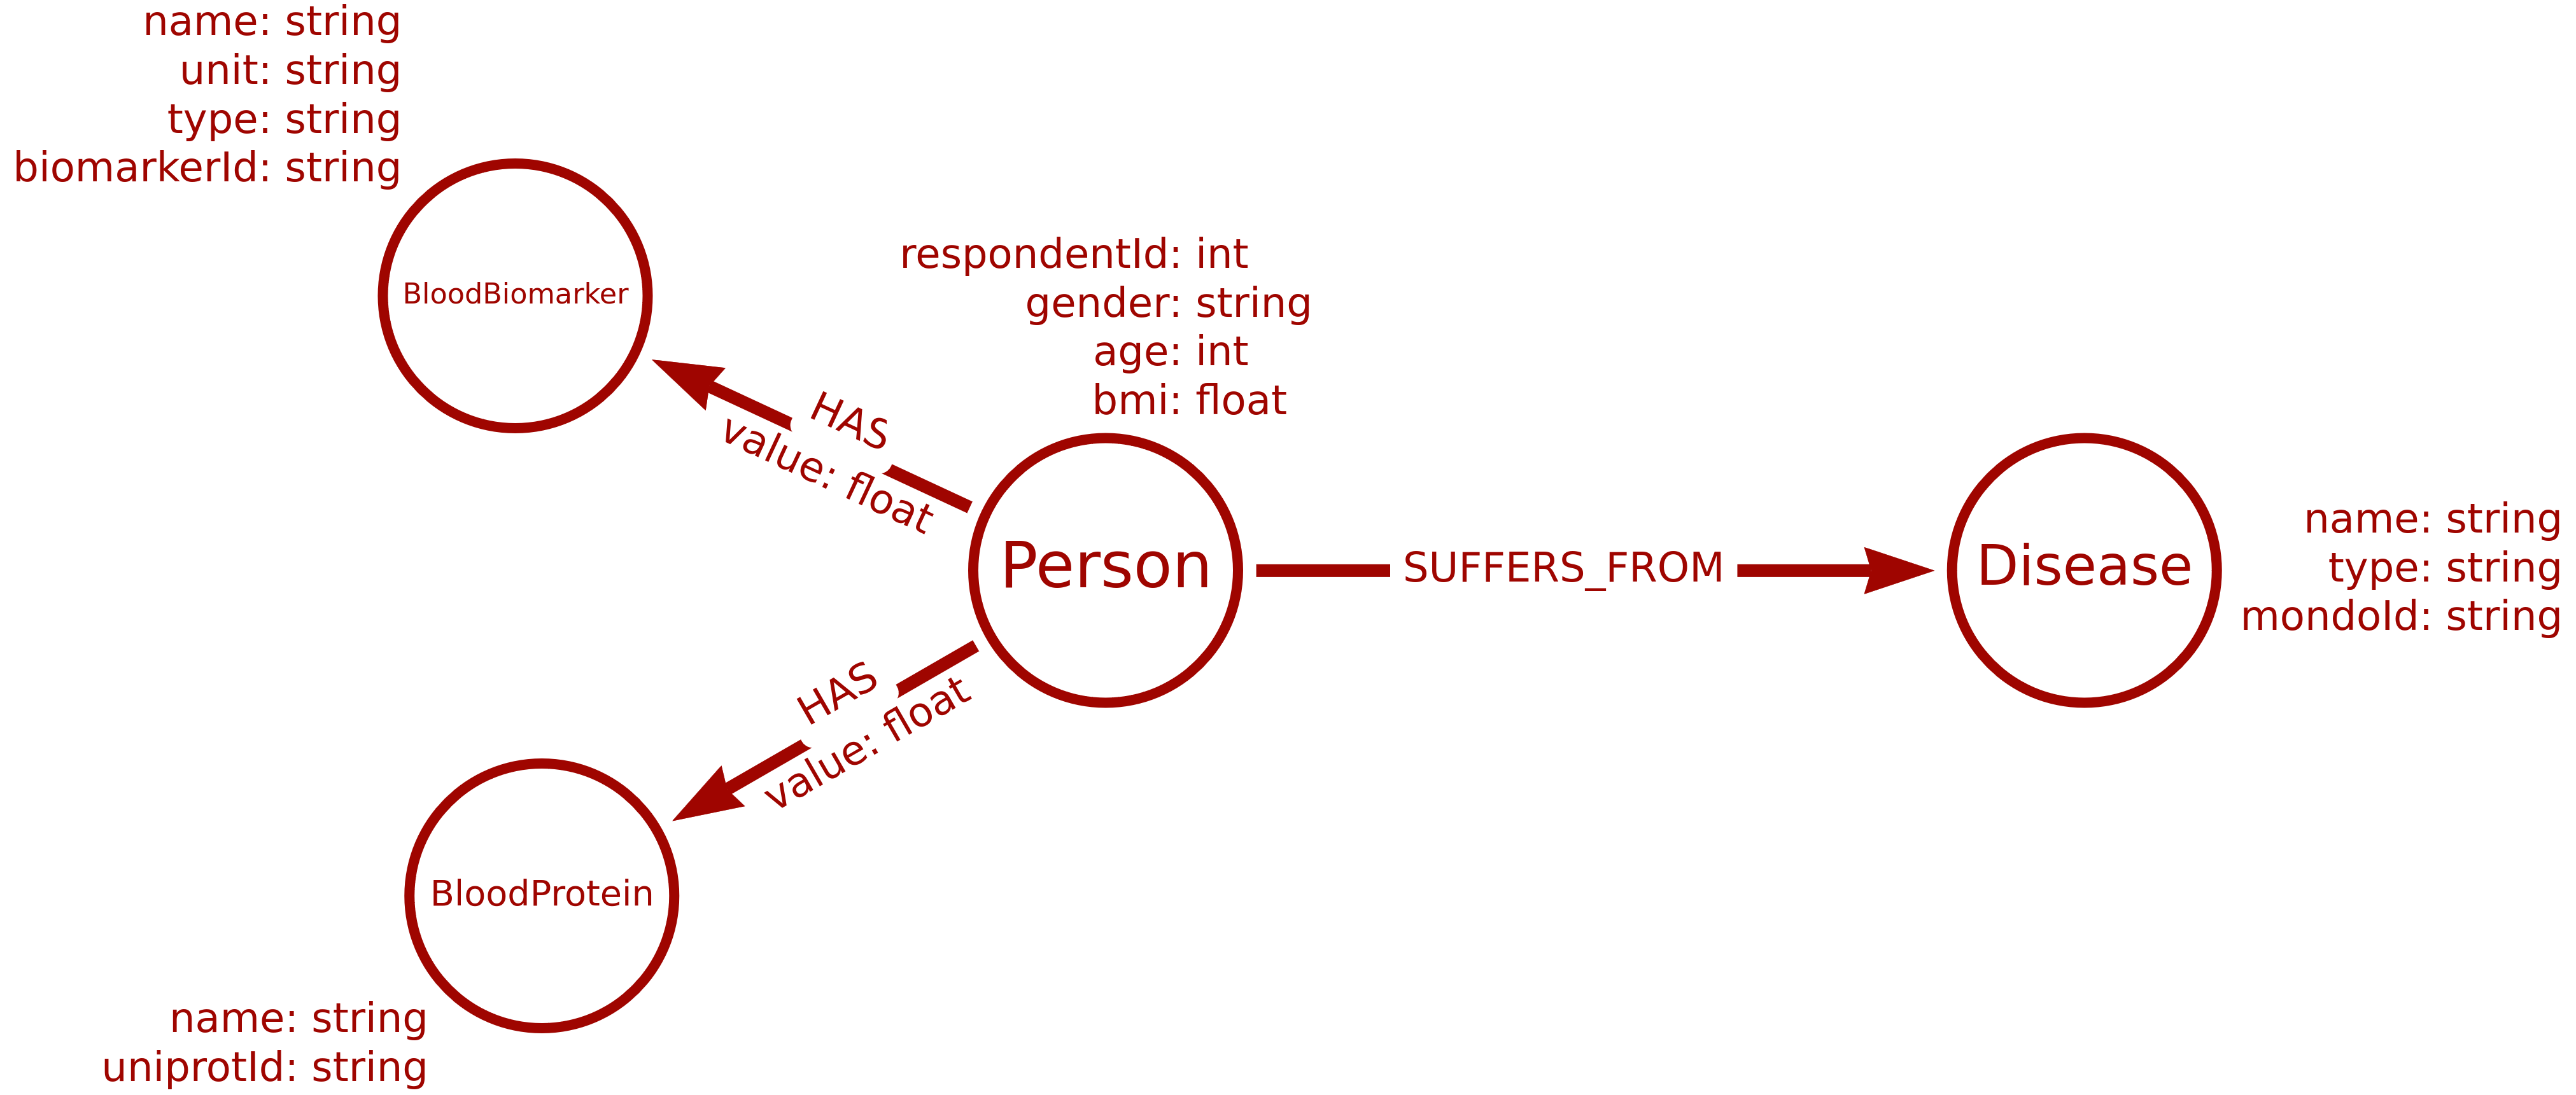

In [29]:
# This will be the graph data model for our knowledge graph

from IPython.display import Image
Image(filename='/home/range/hemo-detect/KG/Graph_data_model.png', width = 900, height = 700)

### Person Node

In [5]:
# Person Node table

person = df[['Respondent ID', 'Gender', 'Age', 'BMI']].copy()
person['Gender'] = person['Gender'].map({0: 'Female', 1: 'Male'})
person['Age'] = person['Age'].astype(int)
person['Respondent ID'] = person['Respondent ID'].astype(int)
person.columns = ['respondentId','gender','age','bmi']
person

,respondentId,gender,age,bmi
0,93703,Female,2,17.5
1,93704,Male,2,15.7
2,93705,Female,66,31.7
3,93706,Male,18,21.5
4,93707,Male,13,18.1
...,...,...,...,...
8892,102952,Female,70,20.0
8893,102953,Male,42,35.8
8894,102954,Female,41,26.1
8895,102955,Female,14,45.6


### BloodBiomarker Node

In [6]:
blood_biomarker = pd.DataFrame(list(df.columns[4:79])+list(df.columns[97:108]),columns=['Name'])
blood_biomarker['Unit'] = ''

In [7]:
# Making a seperate column for units so that it becomes a property
for index, row in blood_biomarker.iterrows():
    for col in blood_biomarker.columns:
        cell_value = row[col]
        unit_start = cell_value.find('[')
        unit_end = cell_value.find(']')
        if unit_start != -1 and unit_end != -1:
            unit = cell_value[unit_start+1:unit_end]
            blood_biomarker.at[index, col] = cell_value[:unit_start].strip()
            blood_biomarker.at[index, 'Unit'] = unit

blood_biomarker.head(10)

,Name,Unit
0,Chromium,nmol/L
1,Cobalt,nmol/L
2,Ferritin,ng/mL
3,Iron frozen,umol/L
4,UIBC,umol/L
5,Total Iron Binding Capacity,umol/L
6,Transferrin Saturation,%
7,Glycohemoglobin,%
8,Triglyceride,mmol/L
9,LDL-Cholesterol(NIH2),mmol/L


In [8]:
# We could also add the protein sequence to the biomarkers that are proteins
# since protein sequences provides useful insights and could even aid in potential drug discovery
# But instead of adding the whole protein sequence, we add the UniProt ID
# UniProt ID provides all the information inlcuding protein sequence and it also acts as a unique ID for the node

# 68 columns do not have a protein sequence
# 18 columns are protein based and hence have protein sequences
# So we make a seperate node for these 18 protein biomarkers

In [9]:
# First we map the type to each biomarker

# Adding a column to indicate the type of blood biomarker
biomarker_type_mapping = {
    '25-hydroxyvitamin D2 + D3': 'Vitamin',
    'Fasting Glucose': 'Blood Sugar',
    'Insulin': 'Hormone (Protein)',
    'Triglyceride': 'Lipoprotein',
    'LDL-Cholesterol(NIH2)': 'Lipoprotein',
    'Vitamin C': 'Vitamin',
    'Alanine Aminotransferase': 'Enzyme (Protein)',
    'Albumin': 'Enzyme (Protein)',
    'Alkaline Phosphatase': 'Enzyme (Protein)',
    'Aspartate Aminotransferase': 'Enzyme (Protein)',
    'Bicarbonate': 'Protein',
    'Blood Urea Nitrogen': 'Waste byproduct',
    'Creatinine': 'Chemical compound',
    'Chloride': 'Electrolytes',
    'Potassium': 'Electrolytes',
    'Sodium': 'Electrolytes',
    'Total Bilirubin': 'Pigment',
    'Total Calcium': 'Electrolytes',
    'Total Protein': 'Proteins',
    'Uric Acid': 'Waste Byproduct',
    'Ferritin': 'Protein',
    'Chromium': 'Mineral',
    'Cobalt': 'Mineral',
    'Cotinine': 'Metabolite',
    'Hydroxycotinine': 'Metabolite',
    'Total Cholesterol': 'Cholesterol',
    'Direct HDL-Cholesterol': 'Lipoprotein',
    'White blood cell count': 'Blood Cells',
    'Lymphocyte': 'Blood Cells',
    'Monocyte': 'Blood Cells',
    'Segmented neutrophils': 'Blood Cells',
    'Eosinophils': 'Blood Cells',
    'Basophils': 'Blood Cells',
    'RBC count': 'Blood Cells',
    'Hemoglobin': 'Protein',
    'Hematocrit': 'Blood Cells',
    'Mean cell volume': 'Blood Cells',
    'Mean cell hemoglobin': 'Blood Cells',
    'Mean Cell Hgb Conc.': 'Blood Cells',
    'Red cell distribution width': 'Blood Cells',
    'Platelet count': 'Blood Cells',
    'Mean platelet volume': 'Blood Cells',
    'Nucleated RBCs': 'Blood Cells',
    'Iron': 'Iron Levels',
    'Iron frozen': 'Iron Levels',
    'UIBC': 'Iron Levels',
    'Total Iron Binding Capacity': 'Iron Levels',
    'Transferrin Saturation': 'Iron Levels',
    'C-Reactive Protein': 'Protein',
    'Alpha-carotene': 'Carotenoids',
    'Alpha-crypotoxanthin': 'Carotenoids',
    'Trans-beta-carotene': 'Carotenoids',
    'Cis-beta-carotene': 'Carotenoids',
    'Beta-cryptoxanthin': 'Carotenoids',
    'Gamma-tocopherol': 'Tocopherols',
    'Alpha-tocopherol': 'Tocopherols',
    'Lutein and zeaxanthin': 'Carotenoids and Retinoids',
    'Trans-lycopene': 'Carotenoids and Retinoids',
    'Retinyl palmitate': 'Carotenoids and Retinoids',
    'Retinyl stearate': 'Carotenoids and Retinoids',
    'Total Lycopene': 'Carotenoids and Retinoids',
    'Retinol': 'Carotenoids and Retinoids',
    'Blood lead': 'Heavy Metals',
    'Blood cadmium': 'Heavy Metals',
    'Blood mercury': 'Heavy Metals',
    'Blood selenium': 'Heavy Metals',
    'Blood manganese': 'Heavy Metals',
    'Transferrin receptor': 'Protein',
    'Glycohemoglobin': 'Blood Sugar',
    'Creatine Phosphokinase': 'Enzyme (Protein)',
    'Globulin': 'Proteins',
    'Gamma Glutamyl Transferase': 'Enzyme (Protein)',
    'Lactate Dehydrogenase': 'Enzyme (Protein)',
    'Osmolality': 'Electrolyte Concentration',
    'Phosphorus': 'Mineral',
    'A/G Ratio': 'Composite Biomarkers',
    'Non_HDL Ratio': 'Composite Biomarkers',
    'LDL_HDL Ratio': 'Composite Biomarkers',
    'Total Cholestrol_HDL Ratio': 'Composite Biomarkers',
    'Triglyceride_HDL Ratio': 'Composite Biomarkers',
    'Lymphocyte_Monocyte Ratio': 'Composite Biomarkers',
    'Neutrophil_Lymphocyte Ratio': 'Composite Biomarkers',
    'Platelet_Lymphocyte Ratio': 'Composite Biomarkers',
    'Platelet_WBC Ratio': 'Composite Biomarkers',
    'Lymphocyte_C-Reactive Protein Ratio': 'Composite Biomarkers',
    'Systemic Immune‐inflammation Index (SII)': 'Composite Biomarkers'}

blood_biomarker['Type'] = blood_biomarker['Name'].map(biomarker_type_mapping)
blood_biomarker.head()

,Name,Unit,Type
0,Chromium,nmol/L,Mineral
1,Cobalt,nmol/L,Mineral
2,Ferritin,ng/mL,Protein
3,Iron frozen,umol/L,Iron Levels
4,UIBC,umol/L,Iron Levels


In [10]:
# Now we exclude the 18 protein based biomarkers

blood_biomarker = blood_biomarker[~blood_biomarker['Type'].str.contains('protein', case=False)]
blood_biomarker.reset_index(drop=True, inplace=True)
blood_biomarker.columns = ['name','unit','type']

In [11]:
# Adding a unique id to each biomarker

blood_biomarker['biomarkerId'] = ['BIO_' + str(i).zfill(3) for i in range(1, len(blood_biomarker) + 1)]

In [12]:
# Blood Biomarker Node Table
blood_biomarker.head(10)

,name,unit,type,biomarkerId
0,Chromium,nmol/L,Mineral,BIO_001
1,Cobalt,nmol/L,Mineral,BIO_002
2,Iron frozen,umol/L,Iron Levels,BIO_003
3,UIBC,umol/L,Iron Levels,BIO_004
4,Total Iron Binding Capacity,umol/L,Iron Levels,BIO_005
5,Transferrin Saturation,%,Iron Levels,BIO_006
6,Glycohemoglobin,%,Blood Sugar,BIO_007
7,Cotinine,ng/mL,Metabolite,BIO_008
8,Hydroxycotinine,ng/mL,Metabolite,BIO_009
9,Blood lead,umol/L,Heavy Metals,BIO_010


### BloodProtein Node

In [13]:
# We now add the protein data to the protein based biomarkers
# Data for the proteins are collected from the UniProt Database

# The URL to access the API of UniProt to download protein sequences of the 18 biomarkers
url = "https://rest.uniprot.org/uniprotkb/accessions?accessions=E7ETN1%2CO00299%2CP00338%2CP01308%2CP02647%2CP02741%2CP02768%2CP02786%2CP02787%2CP02794%2CP04114%2CP05186%2CP06732%2CP17174%2CP24298%2CP55157%2CP69905%2CQ6U841&format=fasta"

fasta_download_dir = "../KG"
if not os.path.exists(fasta_download_dir):
    os.makedirs(fasta_download_dir)

response = requests.get(url)

# Save the sequences as FASTA content to a file
if response.status_code == 200:
    with open("../KG/protein_sequences.fasta", "wb") as fasta_file:
        fasta_file.write(response.content)
    print('Downloaded Protein Sequences as .fasta file')
else:
    print("Failed to retrieve protein sequences.")

Downloaded Protein Sequences as .fasta file


In [14]:
# We use SeqIO from Bio to read from fasta files
# We only read the sequence IDs for the 18 biomarkers that are protein based

from Bio import SeqIO

fasta_file = '../KG/protein_sequences.fasta'

seq_ids = []
protein_names = []

# Reading the FASTA file
for record in SeqIO.parse(fasta_file, 'fasta'):
    protein_names.append(" ".join(record.description.split()[1:4]) if len(record.description.split()) > 1 else '')
    seq_ids.append(record.id)

blood_protein = pd.DataFrame({'Protein': protein_names, 'Sequence_ID': seq_ids})
blood_protein.head()

,Protein,Sequence_ID
0,Gamma-glutamyltransferase 1 (Fragment),tr|E7ETN1|E7ETN1_HUMAN
1,Chloride intracellular channel,sp|O00299|CLIC1_HUMAN
2,L-lactate dehydrogenase A,sp|P00338|LDHA_HUMAN
3,Insulin OS=Homo sapiens,sp|P01308|INS_HUMAN
4,Apolipoprotein A-I OS=Homo,sp|P02647|APOA1_HUMAN


In [15]:
# Now we map each ID to each Biomarker

id_to_protein = {
    'E7ETN1_HUMAN': 'Gamma Glutamyl Transferase', # Gamma-glutamyltransferase 1 
    'CLIC1_HUMAN': 'Chloride',                    # Chloride intracellular channel protein 1
    'LDHA_HUMAN': 'Lactate Dehydrogenase',        # L-lactate dehydrogenase A chain
    'INS_HUMAN': 'Insulin',                       # Insulin
    'APOA1_HUMAN': 'Direct HDL-Cholesterol',      # Apolipoprotein A-I 
    'CRP_HUMAN': 'C-Reactive Protein',            # C-reactive protein 
    'ALBU_HUMAN': 'Albumin',                      # Albumin
    'TFR1_HUMAN': 'Transferrin receptor',         # Transferrin receptor protein 1
    'TRFE_HUMAN': 'Transferrin Saturation',       # Serotransferrin
    'FRIH_HUMAN': 'Ferritin',                     # Ferritin heavy chain
    'APOB_HUMAN': 'LDL-Cholesterol(NIH2)',        # Apolipoprotein B-100 
    'PPBT_HUMAN': 'Alkaline Phosphatase',         # Alkaline phosphatase
    'KCRM_HUMAN': 'Creatine Phosphokinase',       # Creatine kinase M-type 
    'AATC_HUMAN': 'Aspartate Aminotransferase',   # Aspartate aminotransferase
    'ALAT1_HUMAN': 'Alanine Aminotransferase',    # Alanine aminotransferase 1 
    'MTP_HUMAN': 'Triglyceride',                  # Microsomal triglyceride transfer protein large subunit
    'HBA_HUMAN': 'Hemoglobin',                    # Hemoglobin subunit alpha 
    'S4A10_HUMAN': 'Bicarbonate',}                # Sodium-driven chloride bicarbonate exchanger

uniprot_ids = blood_protein['Sequence_ID'].str.split('|').str[-2]
blood_protein['Sequence_ID'] = blood_protein['Sequence_ID'].str.split('|').str[-1]
blood_protein['UniProt_ID'] = uniprot_ids
blood_protein.drop('Protein',axis=1,inplace=True)
blood_protein['Sequence_ID'] = blood_protein['Sequence_ID'].replace(id_to_protein)
blood_protein.columns = ['name', 'uniprotId']

In [16]:
# Protein Node table
blood_protein

,name,uniprotId
0,Gamma Glutamyl Transferase,E7ETN1
1,Chloride,O00299
2,Lactate Dehydrogenase,P00338
3,Insulin,P01308
4,Direct HDL-Cholesterol,P02647
5,C-Reactive Protein,P02741
6,Albumin,P02768
7,Transferrin receptor,P02786
8,Transferrin Saturation,P02787
9,Ferritin,P02794


### Disease Node

In [17]:
disease_df = df[['Respondent ID'] + list(df.columns[81:97])].copy()
disease_df.head()

,Respondent ID,Congestive_Heart_Failure,Coronary_Heart_Disease,Stroke,Thyroid_Problem,Liver_Condition,Jaundice,Cancer,Cancer_Type,Anemia,Heart_Attack,Hepatitis C,Gestational diabetes,Diabetes,Weak/Failing kidneys,Hepatitis A antibody,Hepatitis B core antibody
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1,93704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN
2,93705.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
3,93706.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0
4,93707.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0


In [18]:
# We have a column Cancer_Type which is multiclass and contains a variety of cancer types
# Let us split it into its seperate columns

cancer_mapping = {
    10: 'Bladder Cancer',
    11: 'Blood Cancer',
    12: 'Bone Cancer',
    13: 'Brain Cancer',
    14: 'Breast Cancer',
    15: 'Cervical Cancer',
    16: 'Colon Cancer',
    17: 'Esophageal Cancer',
    18: 'Gallbladder Cancer',
    19: 'Kidney Cancer',
    20: 'Larynx/Windpipe Cancer',
    21: 'Leukemia',
    22: 'Liver Cancer',
    23: 'Lung Cancer',
    24: 'Lymphoma/Hodgkin Disease',
    25: 'Melanoma',
    26: 'Mouth/Tongue/Lip Cancer',
    27: 'Nervous System Cancer',
    28: 'Ovary/Ovarian Cancer',
    29: 'Pancreas/Pancreatic Cancer',
    30: 'Prostate Cancer',
    31: 'Rectum/Rectal Cancer',
    32: 'Skin (Non-Melanoma) Cancer',
    33: 'Skin (Unknown Type) Cancer',
    34: 'Soft Tissue (Muscle or Fat) Cancer',
    35: 'Stomach Cancer',
    36: 'Testis/Testicular Cancer',
    37: 'Thyroid Cancer',
    38: 'Uterus/Uterine Cancer',
}

# Create new columns based on cancer types and rename them
for cancer_type, new_column_name in cancer_mapping.items():
    disease_df[new_column_name] = 0
    disease_df.loc[disease_df['Cancer_Type'] == cancer_type, new_column_name] = 1

disease_df.drop(columns=['Cancer_Type'], inplace=True)
disease_df.head()

,Respondent ID,Congestive_Heart_Failure,Coronary_Heart_Disease,Stroke,Thyroid_Problem,Liver_Condition,Jaundice,Cancer,Anemia,Heart_Attack,...,Pancreas/Pancreatic Cancer,Prostate Cancer,Rectum/Rectal Cancer,Skin (Non-Melanoma) Cancer,Skin (Unknown Type) Cancer,Soft Tissue (Muscle or Fat) Cancer,Stomach Cancer,Testis/Testicular Cancer,Thyroid Cancer,Uterus/Uterine Cancer
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,93704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,93705.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,93706.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,93707.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Let us also replace all the 2 values (which stands for 'Negative') with zeroes.

for column in disease_df.columns:
    disease_df[column] = disease_df[column].replace(2, 0)

disease_df.head()

,Respondent ID,Congestive_Heart_Failure,Coronary_Heart_Disease,Stroke,Thyroid_Problem,Liver_Condition,Jaundice,Cancer,Anemia,Heart_Attack,...,Pancreas/Pancreatic Cancer,Prostate Cancer,Rectum/Rectal Cancer,Skin (Non-Melanoma) Cancer,Skin (Unknown Type) Cancer,Soft Tissue (Muscle or Fat) Cancer,Stomach Cancer,Testis/Testicular Cancer,Thyroid Cancer,Uterus/Uterine Cancer
0,93703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,93704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,93705.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,93706.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,93707.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Disease Node table

disease = pd.DataFrame(list(disease_df.columns[1:45]), columns=['Name'])
disease.head()

,Name
0,Congestive_Heart_Failure
1,Coronary_Heart_Disease
2,Stroke
3,Thyroid_Problem
4,Liver_Condition


In [21]:
# Adding a new column with disease type
disease_type_mapping = {
    'Hepatitis C': 'Liver Disease',
    'Congestive_Heart_Failure': 'Cardiovascular Disease',
    'Coronary_Heart_Disease': 'Cardiovascular Disease',
    'Stroke': 'Cardiovascular Disease',
    'Thyroid_Problem': 'Endocrine Disorder',
    'Liver_Condition': 'Liver Disease',
    'Jaundice': 'Liver Disease',
    'Cancer': 'Cancer',
    'Anemia': 'Blood Disorder',
    'Heart_Attack': 'Cardiovascular Disease',
    'Weak/Failing kidneys': 'Kidney Disease',
    'Gestational diabetes': 'Diabetes',
    'Diabetes': 'Diabetes',
    'Hepatitis A antibody': 'Liver Disease',
    'Hepatitis B core antibody': 'Liver Disease',
    'Bladder Cancer': 'Cancer',
    'Blood Cancer': 'Cancer',
    'Bone Cancer': 'Cancer',
    'Brain Cancer': 'Cancer',
    'Breast Cancer': 'Cancer',
    'Cervical Cancer': 'Cancer',
    'Colon Cancer': 'Cancer',
    'Esophageal Cancer': 'Cancer',
    'Gallbladder Cancer': 'Cancer',
    'Kidney Cancer': 'Cancer',
    'Larynx/Windpipe Cancer': 'Cancer',
    'Leukemia': 'Cancer',
    'Liver Cancer': 'Cancer',
    'Lung Cancer': 'Cancer',
    'Lymphoma/Hodgkin Disease': 'Cancer',
    'Melanoma': 'Cancer',
    'Mouth/Tongue/Lip Cancer': 'Cancer',
    'Nervous System Cancer': 'Cancer',
    'Ovary/Ovarian Cancer': 'Cancer',
    'Pancreas/Pancreatic Cancer': 'Cancer',
    'Prostate Cancer': 'Cancer',
    'Rectum/Rectal Cancer': 'Cancer',
    'Skin (Non-Melanoma) Cancer': 'Cancer',
    'Skin (Unknown Type) Cancer': 'Cancer',
    'Soft Tissue (Muscle or Fat) Cancer': 'Cancer',
    'Stomach Cancer': 'Cancer',
    'Testis/Testicular Cancer': 'Cancer',
    'Thyroid Cancer': 'Cancer',
    'Uterus/Uterine Cancer': 'Cancer'
}

# Mapping each type
disease['Type'] = disease['Name'].map(disease_type_mapping)
disease.head()

,Name,Type
0,Congestive_Heart_Failure,Cardiovascular Disease
1,Coronary_Heart_Disease,Cardiovascular Disease
2,Stroke,Cardiovascular Disease
3,Thyroid_Problem,Endocrine Disorder
4,Liver_Condition,Liver Disease


In [22]:
# Now we need a unique ID for all the diseases 
# We use the Mondo Ontology to obtain the Mondo IDs for each disease and then map these as unique IDs for each disease

mondo_id_mapping = {
    'Hepatitis C': 'MONDO:0005231',
    'Congestive_Heart_Failure': 'MONDO:0005009',
    'Coronary_Heart_Disease': 'MONDO:0005010',
    'Stroke': 'MONDO:0005098',
    'Thyroid_Problem': 'MONDO:0003240',
    'Liver_Condition': 'MONDO:0005154',
    'Jaundice': 'HP:0000952',
    'Cancer': 'MONDO:0004992',
    'Anemia': 'MONDO:0002280',
    'Heart_Attack': 'MONDO:0005068',
    'Weak/Failing kidneys': 'MONDO:0001106',
    'Gestational diabetes': 'MONDO:0005406',
    'Diabetes': 'MONDO:0005015',
    'Hepatitis A antibody': 'MONDO:0005790',
    'Hepatitis B core antibody': 'MONDO:0005344',
    'Bladder Cancer': 'MONDO:0001187',
    'Blood Cancer': 'MONDO:0002334',
    'Bone Cancer': 'MONDO:0002129',
    'Brain Cancer': 'MONDO:0001657',
    'Breast Cancer': 'MONDO:0007254',
    'Cervical Cancer': 'MONDO:0002974',
    'Colon Cancer': 'MONDO:0005575',
    'Esophageal Cancer': 'MONDO:0007576',
    'Gallbladder Cancer': 'MONDO:0005411',
    'Kidney Cancer': 'MONDO:0002367',
    'Larynx/Windpipe Cancer': 'MONDO:0002352',
    'Leukemia': 'MONDO:0005059',
    'Liver Cancer': 'MONDO:0002691',
    'Lung Cancer': 'MONDO:0008903',
    'Lymphoma/Hodgkin Disease': 'MONDO:0005062',
    'Melanoma': 'MONDO:0005105',
    'Mouth/Tongue/Lip Cancer': 'MONDO:0005515',
    'Nervous System Cancer': 'MONDO:0005872',
    'Ovary/Ovarian Cancer': 'MONDO:0008170',
    'Pancreas/Pancreatic Cancer': 'MONDO:0009831',
    'Prostate Cancer': 'MONDO:0002493',
    'Rectum/Rectal Cancer': 'MONDO:0006519',
    'Skin (Non-Melanoma) Cancer': 'MONDO:0020804',
    'Skin (Unknown Type) Cancer': 'MONDO:0002898',
    'Soft Tissue (Muscle or Fat) Cancer': 'MONDO:0018078',
    'Stomach Cancer': 'MONDO:0001056',
    'Testis/Testicular Cancer': 'MONDO:0005447',
    'Thyroid Cancer': 'MONDO:0002108',
    'Uterus/Uterine Cancer': 'MONDO:0002715'
}

# Adding a new column 'MONDO_ID' based on the disease
disease['MONDO_ID'] = disease['Name'].map(mondo_id_mapping)
disease.columns = ['name','type','mondoId']

In [23]:
# Disease Node Table

disease.head(10)

,name,type,mondoId
0,Congestive_Heart_Failure,Cardiovascular Disease,MONDO:0005009
1,Coronary_Heart_Disease,Cardiovascular Disease,MONDO:0005010
2,Stroke,Cardiovascular Disease,MONDO:0005098
3,Thyroid_Problem,Endocrine Disorder,MONDO:0003240
4,Liver_Condition,Liver Disease,MONDO:0005154
5,Jaundice,Liver Disease,HP:0000952
6,Cancer,Cancer,MONDO:0004992
7,Anemia,Blood Disorder,MONDO:0002280
8,Heart_Attack,Cardiovascular Disease,MONDO:0005068
9,Hepatitis C,Liver Disease,MONDO:0005231


### (Person) HAS (BloodBiomarker) Relation

In [24]:
# This HAS relation contains all the values for each blood biomarker for each person

# Modifying the data to match the other dataframes
data = df.copy()
data.rename(columns = {'Respondent ID':'respondentId'}, inplace = True)
data.columns = data.columns.str.replace(r'\s*\[.*\]\s*', '', regex=True)

# Performing a Cartesian product (cross join) between person and blood_biomarker dataframes
person['key'] = 1
blood_biomarker['key'] = 1
p_has_bb = pd.merge(person, blood_biomarker, on='key').drop('key', axis=1)

# Map values from data based on 'respondentId' and 'biomarkerId'
p_has_bb['value'] = p_has_bb.apply(lambda row: data.loc[data['respondentId'] == row['respondentId'],
                                                        row['name']].values[0], axis=1)

p_has_bb = p_has_bb[['respondentId', 'biomarkerId', 'value']]

In [32]:
# The (Person) HAS (BloodBiomarker) relation table

p_has_bb.head(10)

,respondentId,biomarkerId,value
0,93703,BIO_001,6.787297
1,93703,BIO_002,3.653375
2,93703,BIO_003,15.448058
3,93703,BIO_004,43.344840
4,93703,BIO_005,58.796572
5,93703,BIO_006,26.937214
6,93703,BIO_007,5.769562
7,93703,BIO_008,40.370281
8,93703,BIO_009,16.198392
9,93703,BIO_010,0.052326


### (Person) HAS (BloodProtein) Relation

In [24]:
# This HAS relation contains all the values for each blood protein for each person

# Modifying the data to match the other dataframes
data = df.copy()
data.rename(columns = {'Respondent ID':'respondentId'}, inplace = True)
data.columns = data.columns.str.replace(r'\s*\[.*\]\s*', '', regex=True)

# Performing a Cartesian product (cross join) between person and blood_protein dataframes
person['key'] = 1
blood_protein['key'] = 1
p_has_bp = pd.merge(person, blood_protein, on='key').drop('key', axis=1)

# Map values from data based on 'respondentId' and 'biomarkerId'
p_has_bp['value'] = p_has_bp.apply(lambda row: data.loc[data['respondentId'] == row['respondentId'],
                                                        row['name']].values[0], axis=1)

p_has_bp = p_has_bp[['respondentId', 'uniprotId', 'value']]

In [39]:
# The (Person) HAS (BloodProtein) relation table

p_has_bp.head(10)

,respondentId,uniprotId,value
0,93703,E7ETN1,29.689427
1,93703,O00299,101.032690
2,93703,P00338,159.662567
3,93703,P01308,85.453019
4,93703,P02647,1.380910
5,93703,P02741,3.439720
6,93703,P02768,4.078645
7,93703,P02786,40.539759
8,93703,P02787,26.937214
9,93703,P02794,133.394928


### (Person) SUFFERS_FROM (Disease) Relation

In [145]:
# This HAS relation contains all the values for each blood protein for each person

# Modifying the data to match the other dataframes
data = disease_df.copy()
data.rename(columns = {'Respondent ID':'respondentId'}, inplace = True)

# Performing a Cartesian product (cross join) between person and disease dataframes
person['key'] = 1
disease['key'] = 1
suffers_from = pd.merge(person, disease, on='key').drop('key', axis=1)


# Map values from data based on 'respondentId' and 'biomarkerId'
suffers_from['value'] = suffers_from.apply(lambda row: data.loc[data['respondentId'] == row['respondentId'],
                                                        row['name']].values[0], axis=1)
suffers_from = suffers_from[suffers_from['value']==1]
suffers_from.reset_index(drop=True, inplace=True)

suffers_from = suffers_from[['respondentId', 'mondoId']]

In [146]:
# The (Person) SUFFERS_FROM (Disease) relation table

suffers_from.head(10)

,respondentId,mondoId
0,93704,MONDO:0005790
1,93705,MONDO:0005790
2,93705,MONDO:0005344
3,93708,MONDO:0005406
4,93708,MONDO:0005015
5,93708,MONDO:0005790
6,93708,MONDO:0005344
7,93709,MONDO:0005098
8,93709,MONDO:0003240
9,93709,MONDO:0005790
